✅ Module 1 data loaded — shape: (100000, 28), Fraud cases: 50000
✅ Trained XGBoost and LightGBM models loaded!
🚨 High-risk alerts saved: C:\Users\sgvar\project no 1\Module3_RealTime_FraudDetection\Module3_RealTime_FraudDetection\outputs\alerts\high_risk_alerts.csv


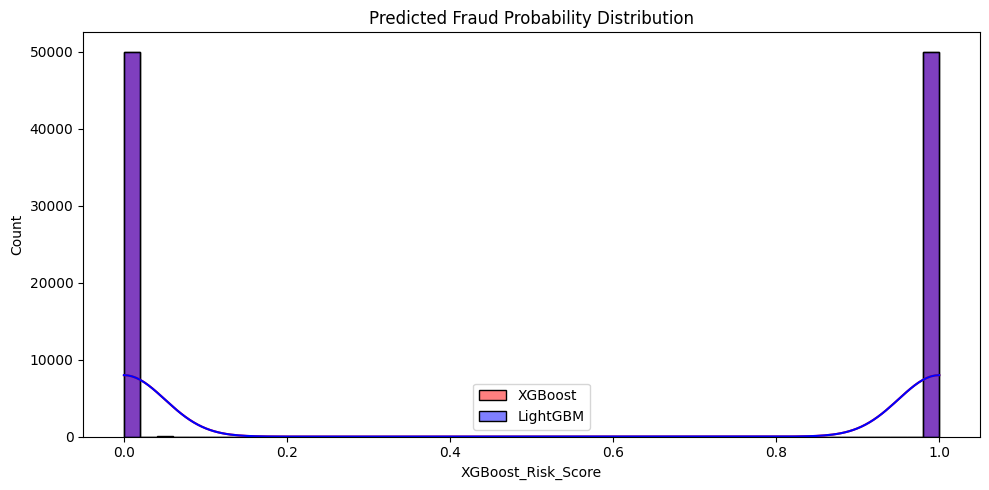

📊 Risk distribution saved: C:\Users\sgvar\project no 1\Module3_RealTime_FraudDetection\Module3_RealTime_FraudDetection\outputs\alerts\visuals\risk_score_distribution.png


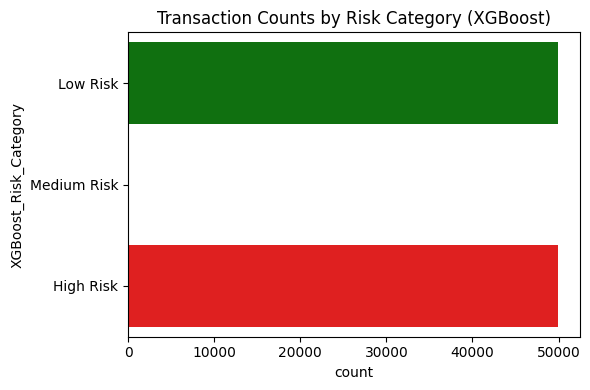

📊 Risk category counts saved: C:\Users\sgvar\project no 1\Module3_RealTime_FraudDetection\Module3_RealTime_FraudDetection\outputs\alerts\visuals\risk_category_counts.png

🚀 BUSINESS INSIGHTS & RECOMMENDATIONS
📈 Total transactions: 100,000
📈 Total fraud cases: 50,000
📈 High-risk transactions: 49,997
📈 Fraud catch rate in high-risk: 100.0%
🎯 Recommended Actions:
 1. BLOCK transactions with risk score ≥ 0.7
 2. REVIEW transactions with risk score 0.3-0.7
 3. AUTO-APPROVE transactions with risk score < 0.3
💾 Full fraud detection results saved: C:\Users\sgvar\project no 1\Module3_RealTime_FraudDetection\Module3_RealTime_FraudDetection\outputs\alerts\module3_fraud_detection_results.csv

🎉 MODULE 3 COMPLETED — Real-time fraud detection and alert generation done!


In [4]:
# =============================================================================
# MODULE 3 — REAL-TIME FRAUD DETECTION ENGINE
# =============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# PATH CONFIGURATION
# -----------------------------------------------------------------------------
BASE_DIR = r"C:\Users\sgvar\project no 1"
MODULE1_DATA = os.path.join(BASE_DIR, "Module1_EDA_Preprocessing", "data", "processed", "card_fraud_processed_module1.csv")
MODULE2_MODELS_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "Module2_Predictive_Modeling", "models", "saved_models")
MODULE3_OUTPUT_ALERTS = os.path.join(BASE_DIR, "Module3_RealTime_FraudDetection", "Module3_RealTime_FraudDetection", "outputs", "alerts")
VISUALS_DIR = os.path.join(MODULE3_OUTPUT_ALERTS, "visuals")

os.makedirs(MODULE3_OUTPUT_ALERTS, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)

# -----------------------------------------------------------------------------
# STEP 1: LOAD PROCESSED DATA
# -----------------------------------------------------------------------------
df = pd.read_csv(MODULE1_DATA)
print(f"✅ Module 1 data loaded — shape: {df.shape}, Fraud cases: {df['isFraud'].sum()}")

# -----------------------------------------------------------------------------
# STEP 2: LOAD TRAINED MODELS (XGBoost & LightGBM)
# -----------------------------------------------------------------------------
xgb_model = joblib.load(os.path.join(MODULE2_MODELS_DIR, "XGBoost_tuned.pkl"))
lgb_model = joblib.load(os.path.join(MODULE2_MODELS_DIR, "LightGBM_tuned.pkl"))
print("✅ Trained XGBoost and LightGBM models loaded!")

# -----------------------------------------------------------------------------
# STEP 3: FEATURE SELECTION
# -----------------------------------------------------------------------------
categorical_columns = ['Transaction_Location', 'Card_Type', 'Transaction_Currency',
                       'Transaction_Status', 'Authentication_Method', 'Transaction_Category']

feature_columns = [
    'Transaction_Amount', 'Previous_Transaction_Count',
    'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min',
    'Transaction_Velocity', 'Log_Transaction_Amount',
    'Transaction_Hour', 'Transaction_Day', 'Transaction_Month'
] + [col + '_encoded' for col in categorical_columns]

X = df[feature_columns]

# -----------------------------------------------------------------------------
# STEP 4: REAL-TIME RISK SCORING
# -----------------------------------------------------------------------------
df['XGBoost_Risk_Score'] = xgb_model.predict_proba(X)[:,1]
df['LightGBM_Risk_Score'] = lgb_model.predict_proba(X)[:,1]

def categorize_risk(score):
    if score >= 0.7:
        return 'High Risk'
    elif score >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['XGBoost_Risk_Category'] = df['XGBoost_Risk_Score'].apply(categorize_risk)
df['LightGBM_Risk_Category'] = df['LightGBM_Risk_Score'].apply(categorize_risk)

# -----------------------------------------------------------------------------
# STEP 5: ALERT GENERATION
# -----------------------------------------------------------------------------
alerts = df[df['XGBoost_Risk_Category'] == 'High Risk'][[
    'Transaction_ID', 'User_ID', 'Transaction_Amount',
    'Transaction_Date', 'Transaction_Time', 'XGBoost_Risk_Score', 'LightGBM_Risk_Score'
]]

alerts_file = os.path.join(MODULE3_OUTPUT_ALERTS, "high_risk_alerts.csv")
alerts.to_csv(alerts_file, index=False)
print(f"🚨 High-risk alerts saved: {alerts_file}")

# -----------------------------------------------------------------------------
# STEP 6: VISUALIZATIONS
# -----------------------------------------------------------------------------
# 1️⃣ Risk distribution
plt.figure(figsize=(10,5))
sns.histplot(df['XGBoost_Risk_Score'], bins=50, color='red', label='XGBoost', kde=True)
sns.histplot(df['LightGBM_Risk_Score'], bins=50, color='blue', label='LightGBM', kde=True)
plt.title('Predicted Fraud Probability Distribution')
plt.legend()
plt.tight_layout()
risk_dist_path = os.path.join(VISUALS_DIR, "risk_score_distribution.png")
plt.savefig(risk_dist_path)
plt.show()
print(f"📊 Risk distribution saved: {risk_dist_path}")

# 2️⃣ Risk category counts
plt.figure(figsize=(6,4))
sns.countplot(df['XGBoost_Risk_Category'], order=['Low Risk','Medium Risk','High Risk'], palette=['green','orange','red'])
plt.title('Transaction Counts by Risk Category (XGBoost)')
plt.tight_layout()
risk_cat_path = os.path.join(VISUALS_DIR, "risk_category_counts.png")
plt.savefig(risk_cat_path)
plt.show()
print(f"📊 Risk category counts saved: {risk_cat_path}")

# -----------------------------------------------------------------------------
# STEP 7: BUSINESS INSIGHTS
# -----------------------------------------------------------------------------
total_fraud = df['isFraud'].sum()
high_risk_fraud = df[(df['XGBoost_Risk_Category']=='High Risk') & (df['isFraud']==1)].shape[0]
catch_rate = high_risk_fraud / total_fraud if total_fraud>0 else 0

print("\n🚀 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*50)
print(f"📈 Total transactions: {len(df):,}")
print(f"📈 Total fraud cases: {total_fraud:,}")
print(f"📈 High-risk transactions: {len(df[df['XGBoost_Risk_Category']=='High Risk']):,}")
print(f"📈 Fraud catch rate in high-risk: {catch_rate*100:.1f}%")
print("🎯 Recommended Actions:")
print(" 1. BLOCK transactions with risk score ≥ 0.7")
print(" 2. REVIEW transactions with risk score 0.3-0.7")
print(" 3. AUTO-APPROVE transactions with risk score < 0.3")

# -----------------------------------------------------------------------------
# STEP 8: SAVE FULL RESULTS
# -----------------------------------------------------------------------------
results_file = os.path.join(MODULE3_OUTPUT_ALERTS, "module3_fraud_detection_results.csv")
df.to_csv(results_file, index=False)
print(f"💾 Full fraud detection results saved: {results_file}")

print("\n🎉 MODULE 3 COMPLETED — Real-time fraud detection and alert generation done!")


In [3]:
print(df.columns)


Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Date',
       'Transaction_Time', 'Transaction_Location', 'Merchant_ID', 'Device_ID',
       'Card_Type', 'Transaction_Currency', 'Transaction_Status',
       'Previous_Transaction_Count', 'Distance_Between_Transactions_km',
       'Time_Since_Last_Transaction_min', 'Authentication_Method',
       'Transaction_Velocity', 'Transaction_Category', 'isFraud',
       'Transaction_Hour', 'Transaction_Day', 'Transaction_Month',
       'Log_Transaction_Amount', 'Transaction_Location_encoded',
       'Card_Type_encoded', 'Transaction_Currency_encoded',
       'Transaction_Status_encoded', 'Authentication_Method_encoded',
       'Transaction_Category_encoded', 'XGBoost_Risk_Score',
       'LightGBM_Risk_Score', 'XGBoost_Risk_Category',
       'LightGBM_Risk_Category'],
      dtype='object')
